<a href="https://colab.research.google.com/github/Mohamed-Mohamed-Ibrahim/Face-Recognition/blob/main/GMM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from sklearn.mixture import GaussianMixture
X = np.array([[1, 2], [1, 4], [1, 0], [10, 2], [10, 4], [10, 0]])
gm = GaussianMixture(n_components=2, random_state=0).fit(X)
gm.means_
gm.predict([[0, 0], [12, 3]])

array([1, 0])

100%|██████████| 26.4M/26.4M [00:00<00:00, 116MB/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 5.03MB/s]

Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw




100%|██████████| 4.42M/4.42M [00:00<00:00, 62.0MB/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 13.7MB/s]


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



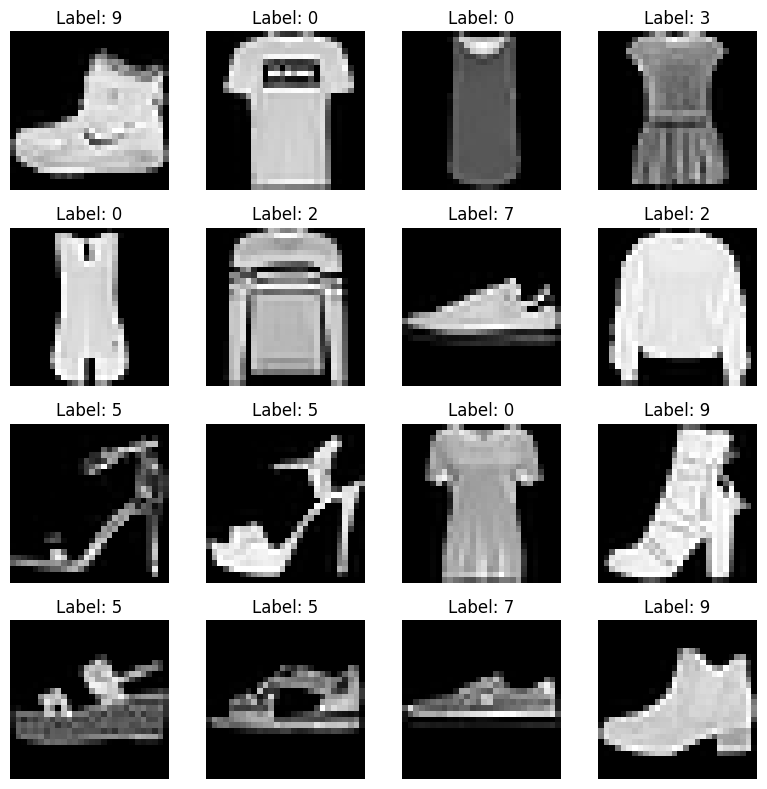

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

X = np.array([np.arange(28)])
y = np.array([])

# Define the transformation
transform = transforms.ToTensor()

# Load the dataset
train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)

# Create a subplot with 4x4 grid
fig, axs = plt.subplots(4, 4, figsize=(8, 8))

# Loop through each subplot and plot an image
for i in range(4):
    for j in range(4):
        image, label = train_dataset[i * 4 + j]  # Get image and label
        image_numpy = image.numpy().squeeze()    # Convert image tensor to numpy array
        # print(len(image_numpy))
        X = np.append(X, image_numpy, axis=0)
        y = np.append(y, label)
        axs[i, j].imshow(image_numpy, cmap='gray')  # Plot the image
        axs[i, j].axis('off')  # Turn off axis
        axs[i, j].set_title(f"Label: {label}")  # Set title with label
X = np.delete(X, 0, axis=0)

plt.tight_layout()  # Adjust layout
plt.show()  # Show plot


In [3]:
print(f"X: {X}, size: {X.shape}")
print(f"y: {y}, size: {len(y)}")

X: [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]], size: (448, 28)
y: [9. 0. 0. 3. 0. 2. 7. 2. 5. 5. 0. 9. 5. 5. 7. 9.], size: 16


In [34]:
import numpy as np
from sklearn.base import BaseEstimator, RegressorMixin
from scipy.stats import multivariate_normal


class GMM(BaseEstimator, RegressorMixin):
    def __init__(self, n_components=1, tol=0.001, reg_covar=1e-06, max_iter=100, verbose=False, n_init=10):
        self.n_components = n_components
        self.tol = tol
        self.reg_covar = reg_covar
        self.max_iter = max_iter
        self.verbose = verbose
        self.n_init = n_init
        self.means_ = None
        self.covariances_ = None
        self.weights_ = None

    def fit(self, X):
        best_m = None
        best_c = None
        best_w = None
        best_log_likelihood = -np.inf

        for _ in range(self.n_init):
            self.__fit(X)
            ll = self.score(X)
            if ll > best_log_likelihood:
                best_log_likelihood = ll
                best_m = self.means_
                best_c = self.covariances_
                best_w = self.weights_
            self.means_ = None
            self.covariances_ = None
            self.weights_ = None
        self.means_ = best_m
        self.covariances_ = best_c
        self.weights_ = best_w


    def __fit(self, X):

        n_samples, n_features = X.shape
        self.means_ = np.random.rand(self.n_components, n_features)*20 - 10
        self.covariances_ = np.zeros((self.n_components, n_features, n_features))
        for i in range(self.n_components):
            self.covariances_[i] = np.eye(n_features)
        self.weights_ = (1/self.n_components) + np.zeros(self.n_components)

        r = np.zeros((self.n_components, n_samples))

        for _ in range(self.max_iter):

            if self.verbose and self.max_iter % 50 == 0:
                print(f"Iteration: {_} -> Means {self.means_} -> Var {self.covariances_} -> Weights {self.weights_}")

            # E-step
            # Assign r using posterior probability
            for i in range(self.n_components):
                r[i, :] = self.weights_[i] * multivariate_normal.pdf(X, self.means_[i], self.covariances_[i])

            # Normalization
            for i in range(n_samples):
                r[:, i] = r[:, i] / np.sum(r[:, i])

            old_w = self.weights_.copy()
            old_m = self.means_.copy()
            old_c = self.covariances_.copy()

            # M-step
            for i in range(self.n_components):

                self.weights_[i] = np.sum(r[i, :]) / n_samples

                for j in range(n_features):
                    self.means_[i][j] = np.sum(r[i, :] * X[:, j]) / np.sum(r[i, :])
                # self.means_[i] = (r[i, :, np.newaxis] * X).sum(axis=0) / np.sum(r[i, :])
                    for k in range(n_features):
                        self.covariances_[i][j, k] = np.sum(r[i, :] * (X[:, j] - self.means_[i][j]) * (X[:, k] - self.means_[i][k])) / np.sum(r[i, :])

                # diff = X - self.means_[i]
                # self.covariances_[i] = (r[i, :, np.newaxis, np.newaxis] * np.einsum('ni,nj->nij', diff, diff)).sum(axis=0) / np.sum(r[i, :])

                # Regularize covariance
                self.covariances_[i] += self.reg_covar * np.eye(n_features)

            if np.all(np.abs(old_w - self.weights_) < self.tol) and np.all(np.abs(old_m - self.means_) < self.tol) and np.all(np.abs(old_c - self.covariances_) < self.tol):
                break


    def predict(self, X):
        n_samples = len(X)

        r = np.zeros((self.n_components, n_samples))

        for i in range(self.n_components):
            r[i, :] = self.weights_[i] * multivariate_normal.pdf(X, self.means_[i], self.covariances_[i])

        return np.argmax(r, axis=0)

    def score(self, X):
        ll = []
        for d in X:
            tot = 0
            for k in range(self.n_components):
                tot += self.weights_[k] * multivariate_normal.pdf(X, mean=self.means_[k], cov=self.covariances_[k])
            ll.append(np.log(tot))
        return np.sum(ll)

In [8]:
import numpy as np
from sklearn.mixture import GaussianMixture
X = np.array([[1, 2], [1, 4], [1, 0], [10, 2], [10, 4], [10, 0]])
gm = GaussianMixture(n_components=2, verbose=1).fit(X)
print(gm.means_)
print(gm.covariances_)
print(gm.weights_)
gm.predict([[0, 0], [12, 3]])

Initialization 0
Initialization converged: True
[[10.  2.]
 [ 1.  2.]]
[[[1.00000000e-06 1.15699599e-29]
  [1.15699599e-29 2.66666767e+00]]

 [[1.00000000e-06 1.24902977e-30]
  [1.24902977e-30 2.66666767e+00]]]
[0.5 0.5]


array([1, 0])

In [22]:
X = np.array([[1, 2], [1, 4], [1, 0], [10, 2], [10, 4], [10, 0]])
gmm = GMM(n_components=2, n_init=5)
gmm.fit(X)
print(gmm.means_)
print(gmm.covariances_)
print(gmm.weights_)
print(gmm.predict([[0, 0], [12, 3]]))
gmm.log_likelihood(X)

[[ 1.  2.]
 [10.  2.]]
[[[1.00000000e-06 0.00000000e+00]
  [0.00000000e+00 2.66666767e+00]]

 [[1.00000000e-06 0.00000000e+00]
  [0.00000000e+00 2.66666767e+00]]]
[0.5 0.5]
[0 0]


121.90739059825013

# Testing

/tmp/ipykernel_31/1328154172.py:7: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X[:, 0], X[:, 1], s=30, cmap='viridis')


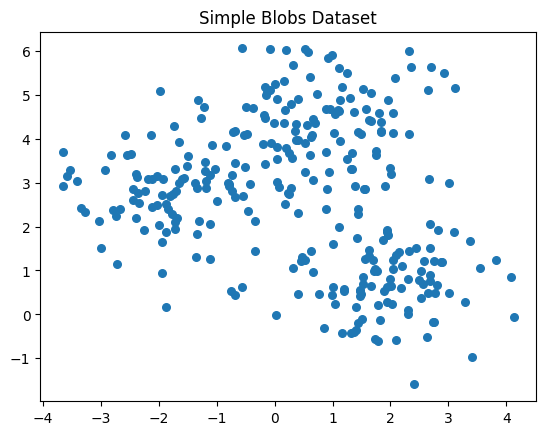

In [28]:
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt

# Generate synthetic data
X, y_true = make_blobs(n_samples=300, centers=3, cluster_std=0.90, random_state=0)

plt.scatter(X[:, 0], X[:, 1], s=30, cmap='viridis')
plt.title("Simple Blobs Dataset")
plt.show()


# Resourses

- https://www.geeksforgeeks.org/how-to-load-fashion-mnist-dataset-using-pytorch/
- https://youtu.be/wT2yLNUfyoM
- https://scikitlearn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html#sklearn.mixture.GaussianMixture
- https://github.com/scikit-learn/scikit-learn/blob/98ed9dc73/sklearn/mixture/_gaussian_mixture.py#L509

# Evaluation

# Fine Tuning 

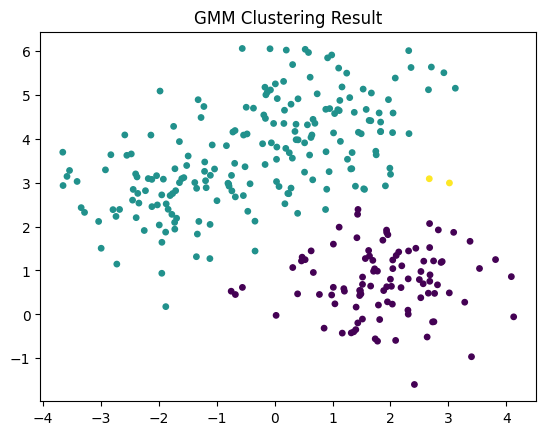

In [37]:
gmm = GMM(n_components=3, tol=1e-9, max_iter=100)
gmm.fit(X)
labels = gmm.predict(X)


plt.scatter(X[:, 0], X[:, 1], c=labels, s=15, cmap='viridis')
plt.title("GMM Clustering Result")
plt.show()
